---

<div align="center">

# Copyright and Credit Notice

**Jupyter Lab created by**

**Prof. Hyunglok Kim**

**Hydro AI Lab, GIST, South Korea**

Website: [hydroai.net](http://hydroai.net)

---

**Commercial Use Prohibited**

None of the materials may be used commercially. Please contact me if you plan to modify and use these materials for any educational purpose or research.

---

**Contact Information**

Prof. Hyunglok Kim  
Hydro AI Lab, GIST, South Korea  
Email: [hyunglokkim@gist.ac.kr](mailto:hyunglokkim@gist.ac.kr)

---

</div>

<span style="font-size: 24px; color: blue; font-weight: bold;"> Step 2 (Developing a machine learning model to predict water quality)</span>
## 1. Import Necssary Python Libraries

In [12]:
import sys
import os
import platform
import importlib
import glob

import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#ML libs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import xgboost as xgb

#hydroAI libs
import HydroAI.Plot as Plot
import HydroAI.Data as Data
import HydroAI.HLS as HLS

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
    
# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Set the Water Qualiuty and Sentinel-2 Data Directroy

In [2]:
target_date = '2022.01.10'

data_path = '/Conferences/2024_수자원학회/SJ'
S30_or = pd.read_csv(base_FP + data_path + '/merged_S30_obs_Juam.csv')

nc_file = nc.Dataset ('/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive/Conferences/2024_수자원학회/SJ/Pekel_Juam_resampled.nc', 'r')
pekel_water = nc_file.variables['pekel_data'] [:]
nc_file.close()

base_folder = '/Users/hyunglokkim/cpuserver_data/HLS/Juam/S30/'+target_date

## 3. Data Pre-processing

In [3]:
S30 = S30_or.copy()
S30['time_delta'] = S30['time_delta']/60/60
S30.rename(columns={'time_delta':'time_delta_hr'}, inplace=True)
S30.rename(columns={'nir_narrow':'red_edge4'}, inplace=True)

S30_m = S30.copy()
S30_m['cloud'] = HLS.is_cloud(S30_m.qa)
S30_m['water'] = HLS.is_water(S30_m.qa)
S30_m = S30_m[(S30_m.cloud == 0) & (S30_m.water == 1) & (np.abs(S30_m.time_delta_hr)<=60)]

selected_X = ['blue', 'green', 'red', 'red_edge1', 'red_edge2', 'red_edge3', 'red_edge4',
              'nir', 'swir1', 'swir2'] 

selected_Y = ['itemCloa'] 
selected_columns = selected_X + selected_Y

S30_m = S30_m[selected_columns].dropna().reset_index().drop(columns='index')

# Split the data into features(X; Sentinel-2 data) and target(y; Chlorophyll a)
X = S30_m[selected_X]
Y = S30_m[selected_Y].values.ravel()

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=321)

# Normalization scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaling to the test data
X_test_scaled = scaler.transform(X_test)

## 4. Find important features(X) for ML models (advanced)

In [4]:
# Initial fit to determine feature importances using Randome Forest Method
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train_scaled, Y_train)

# Get feature importances
importances = forest.feature_importances_

# Features above a certain threshold
threshold = np.sort(importances)[-8]  # adjust the threshold or number of features as needed
selected_features = [x for x, imp in zip(selected_X, importances) if imp >= threshold]

# Filter the training and testing sets to include only selected features
X_train_scaled = X_train_scaled[:, [selected_X.index(feature) for feature in selected_features]]
X_test_scaled = X_test_scaled[:, [selected_X.index(feature) for feature in selected_features]]

## 5. Build a XGBoost model
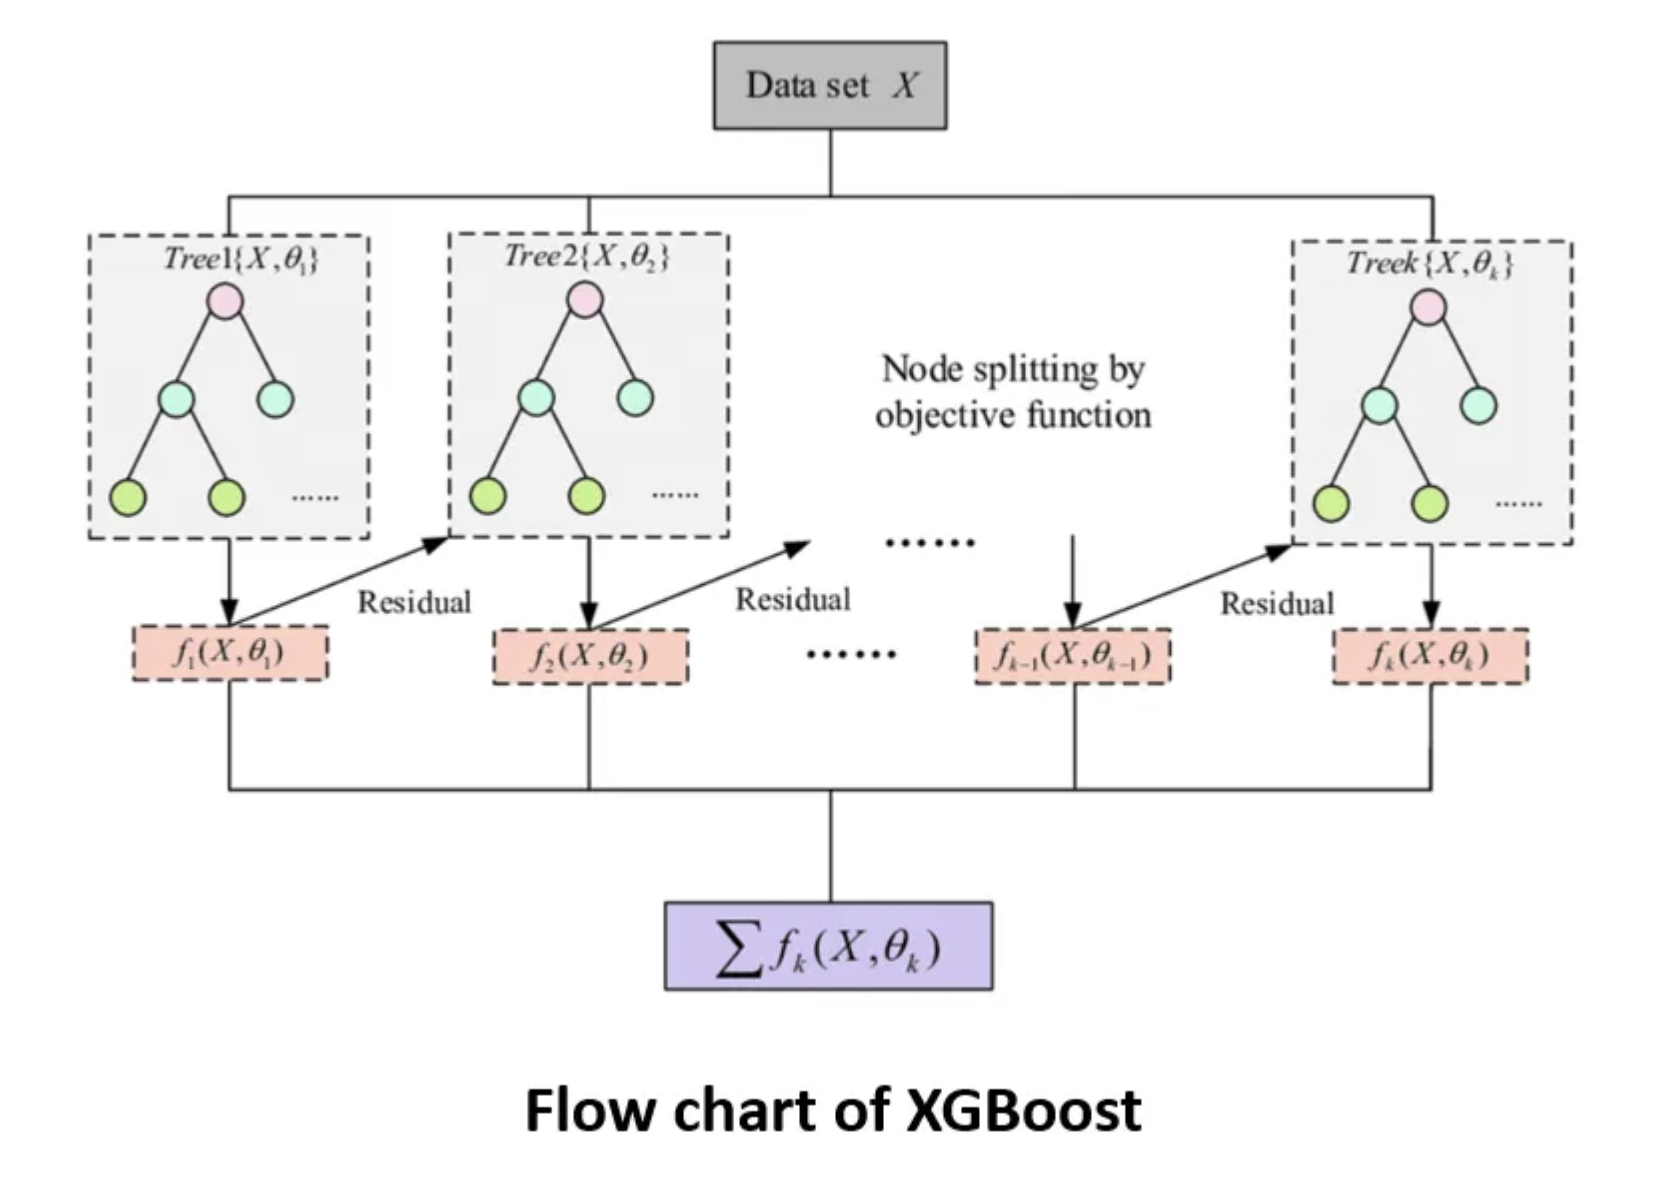

### Simple XGBoost Model

XGBoost (eXtreme Gradient Boosting) is a powerful and efficient implementation of gradient boosting for supervised learning problems. It is widely used for its performance and speed in both regression and classification tasks.

### Key Features of XGBoost

- **Regularization**: Helps prevent overfitting by adding penalties to the model.
- **Parallel Processing**: Utilizes multiple CPU cores for faster training.
- **Handling Missing Values**: XGBoost can handle missing values internally.
- **Tree Pruning**: Uses a technique called "max depth" to prevent overfitting by pruning the trees.

## 6. Create a pipeline with scaling and the XGBoost regressor
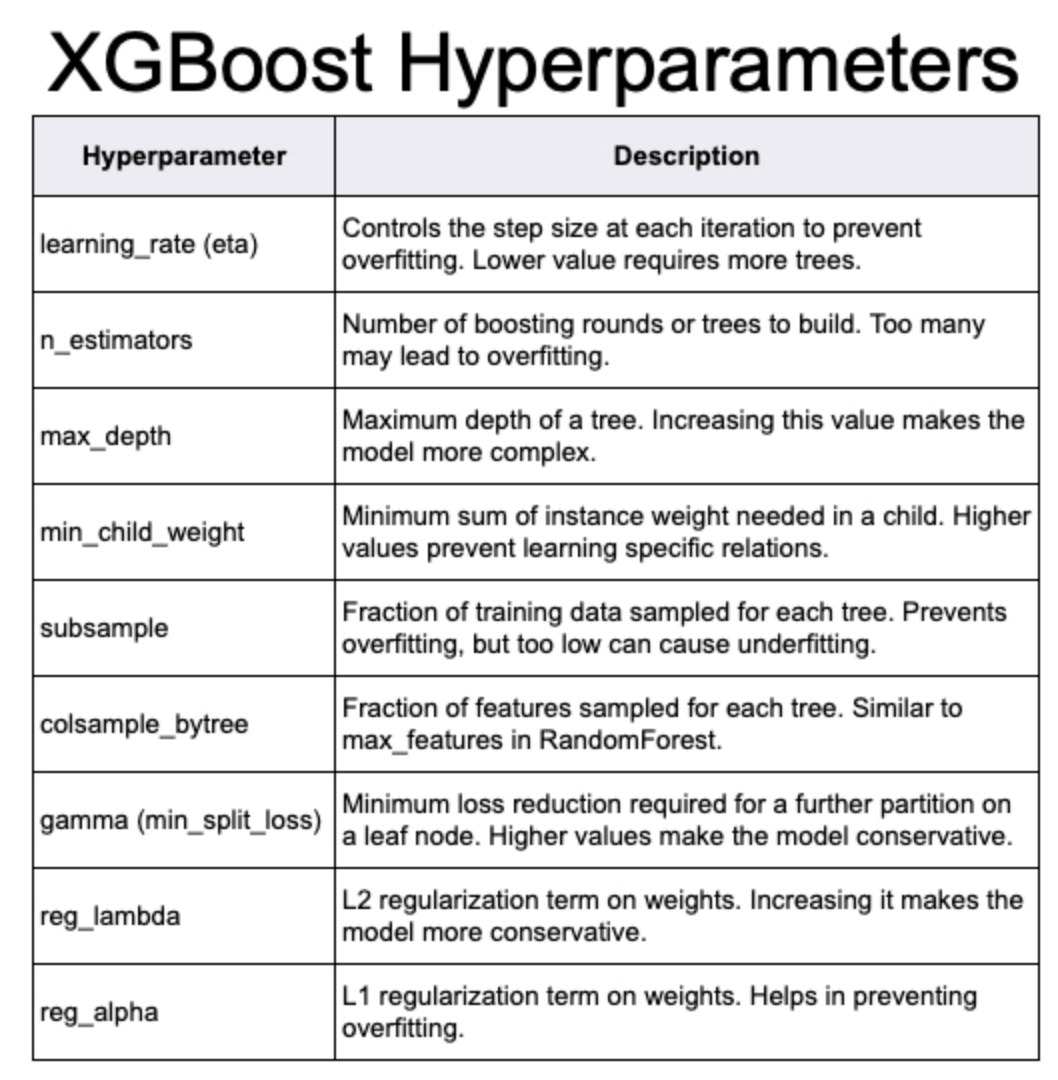

In [5]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=321))
])

# Define the search space for Bayesian optimization
search_spaces = {
    'xgb__n_estimators': Integer(100, 500),  # Increased number of estimators
    'xgb__max_depth': Integer(3, 10),  # Reduced max depth to control complexity
    'xgb__learning_rate': Real(0.01, 0.1, prior='log-uniform'),  # Lower learning rate
    'xgb__subsample': Real(0.7, 1.0),  # Slightly more conservative subsample
    'xgb__colsample_bytree': Real(0.7, 1.0),  # More conservative feature sampling
    'xgb__min_child_weight': Integer(3, 10),  # Increased min child weight
    'xgb__gamma': Real(0.1, 1.0),  # Adding gamma to control loss reduction
    'xgb__lambda': Real(1, 10),  # L2 regularization
    'xgb__alpha': Real(0.1, 1.0)  # L1 regularization
}

## 7. Bayesian optimization (advanced)

### Bayesian Optimization

Bayesian Optimization is a sequential design strategy for global optimization of black-box functions that does not assume any functional form. It is particularly useful when the objective function is expensive to evaluate.

### Key Concepts

1. **Surrogate Model**: Bayesian Optimization uses a surrogate model, typically a Gaussian Process (GP), to model the objective function. The surrogate model is cheaper to evaluate and provides a probabilistic estimate of the objective function.

2. **Acquisition Function**: The acquisition function guides the search for the next point to evaluate by balancing exploration (searching new areas) and exploitation (refining known good areas). Common acquisition functions include Expected Improvement (EI), Probability of Improvement (PI), and Upper Confidence Bound (UCB).

3. **Sequential Optimization**: Bayesian Optimization iteratively updates the surrogate model with new data points, gradually improving its accuracy and leading to better optimization results over time.

### Steps in Bayesian Optimization

1. **Initialize**: Start with a set of initial data points and their corresponding objective function values.
2. **Surrogate Model Fitting**: Fit a surrogate model to the existing data.
3. **Acquisition Function Maximization**: Use the acquisition function to select the next point to evaluate.
4. **Evaluate Objective Function**: Evaluate the objective function at the selected point.
5. **Update**: Update the surrogate model with the new data point.
6. **Iterate**: Repeat steps 3-5 until a stopping criterion is met (e.g., a maximum number of iterations or convergence).

### Advantages

- **Efficiency**: Bayesian Optimization is efficient for optimizing expensive functions, as it requires fewer function evaluations.
- **Probabilistic**: The surrogate model provides uncertainty estimates, which are useful for understanding the optimization process.

### Applications

- **Hyperparameter Tuning**: Commonly used in machine learning for tuning hyperparameters of models.
- **Experimental Design**: Used in scientific experiments and industrial processes to optimize settings and improve outcomes.

In summary, Bayesian Optimization is a powerful method for optimizing complex, expensive functions by building and iteratively refining a probabilistic model.

In [6]:
# Initialize Bayesian optimization with the pipeline
xgb_opt = BayesSearchCV(
    estimator=xgb_pipeline,
    search_spaces=search_spaces,
    n_iter=8,  # Number of iterations to perform
    cv=10,  # Cross-validation folds
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=321,
    verbose=1
)

# Fit the Bayesian optimizer
xgb_opt.fit(X_train_scaled, Y_train)  # No need to scale X_train here as it's done in the pipeline

# Best model and parameters found
print("Best XGBoost parameters:", xgb_opt.best_params_)
best_xgb_model = xgb_opt.best_estimator_

# Make predictions
Y_test_pred_xgb = best_xgb_model.predict(X_test_scaled)  # X_test is automatically scaled in the pipeline
Y_train_pred_xgb = best_xgb_model.predict(X_train_scaled)

# Calculate and print RMSE
xgb_test_rmse = rmse(Y_test, Y_test_pred_xgb)
print("Test RMSE for XGBoost:", xgb_test_rmse)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best XGBoost parameters: OrderedDict({'xgb__alpha': 0.3620575735215593, 'xgb__colsample_bytree': 0.795906867823678, 'xgb__gamma': 0.8132845834598216, 'xgb__lambda': 4.826372610169496, 'xgb__learning_rate': 0.08097349465836502, 'xgb__max_depth': 4, 'xgb__min_child_weight': 4, 'xgb__n_estimators': 223, 'xgb__subsample': 0.7770519783181049})
Test RMSE for XGBoost: 1.7274991218609366


## 8. Model Validation


## Training Data 1:1 Plot vs Testing Data 1:1 Plot in Machine Learning

In machine learning, 1:1 plots (also known as parity plots or scatter plots) are used to compare the predicted values against the actual values. These plots are valuable for visualizing the performance of a model. Here's a discussion on comparing training data 1:1 plots with testing data 1:1 plots:

### Training Data 1:1 Plot

The training data 1:1 plot shows the relationship between the predicted values and the actual values on the training dataset.

- **Purpose**: To assess how well the model has learned from the training data.
- **Ideal Scenario**: In an ideal scenario, the points on this plot should lie close to the 45-degree line, indicating that the predicted values match the actual values.
- **Interpretation**:
  - Points close to the line indicate good predictions.
  - Points far from the line indicate poor predictions or overfitting if the model performs much better on training data than on testing data.

### Testing Data 1:1 Plot

The testing data 1:1 plot shows the relationship between the predicted values and the actual values on the testing dataset.

- **Purpose**: To evaluate the model's generalization performance on unseen data.
- **Ideal Scenario**: In an ideal scenario, the points should also lie close to the 45-degree line, similar to the training plot.
- **Interpretation**:
  - Points close to the line indicate good generalization.
  - Points far from the line suggest poor generalization or overfitting if the training plot was much closer to the line.

### Comparing Training and Testing 1:1 Plots

#### Overfitting
- **Indication**: If the training plot shows points close to the 45-degree line but the testing plot shows points far from the line.
- **Cause**: The model has learned the noise in the training data and fails to generalize.

#### Underfitting
- **Indication**: If both the training and testing plots show points far from the 45-degree line.
- **Cause**: The model is too simple to capture the underlying patterns in the data.

#### Good Fit
- **Indication**: If both plots show points close to the 45-degree line.
- **Cause**: The model has learned the patterns in the data well and generalizes appropriately.

### Practical Steps

1. **Plotting**: Create 1:1 plots for both training and testing data using tools like Matplotlib or Seaborn.
2. **Analysis**: Compare the plots to diagnose issues like overfitting or underfitting.
3. **Model Tuning**: Adjust model complexity, regularization, or other hyperparameters based on the analysis.

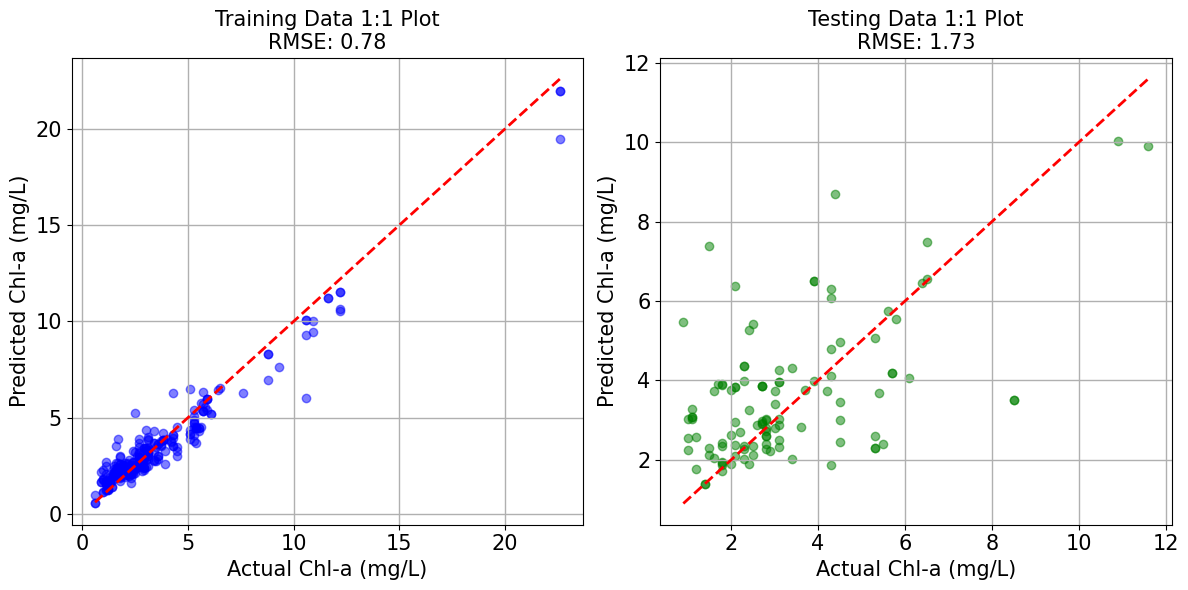

In [7]:
train_rmse = rmse(Y_train_pred_xgb, Y_train)
test_rmse = rmse(Y_test_pred_xgb, Y_test)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plot for Training Results
ax[0].scatter(Y_train, Y_train_pred_xgb, alpha=0.5, color='blue')
ax[0].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], '--r', linewidth=2)
ax[0].set_xlabel('Actual Chl-a (mg/L)')
ax[0].set_ylabel('Predicted Chl-a (mg/L)')
ax[0].set_title(f'Training Data 1:1 Plot\nRMSE: {train_rmse:.2f}')
ax[0].grid(True)

# Plot for Testing Results
ax[1].scatter(Y_test, Y_test_pred_xgb, alpha=0.5, color='green')
ax[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', linewidth=2)
ax[1].set_xlabel('Actual Chl-a (mg/L)')
ax[1].set_ylabel('Predicted Chl-a (mg/L)')
ax[1].set_title(f'Testing Data 1:1 Plot\nRMSE: {test_rmse:.2f}')
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

<span style="font-size: 24px; color: blue; font-weight: bold;"> Step 3: Predict Chlorophyll a and create a predicted-Chlorophyll a map</span>: 


In [13]:
feature_indices = [selected_X.index(feature) for feature in selected_features if feature in selected_X]
s2_reader = HLS.SentinelBandReader(base_folder)

# Dynamically load band data using names in selected_X
band_data = [getattr(s2_reader, band) for band in selected_features if hasattr(s2_reader, band)]
# Stack all band data along the third axis
s2_data = np.dstack(band_data)
qa_data = s2_reader.qa*10000
lon, lat = s2_reader.get_lat_lon_arrays('red')

pekel_water_mask = (pekel_water > 0)
final_mask = pekel_water_mask

height, width, _ = s2_data.shape
pred_2d_xgb = np.full((height, width), np.nan)  # Initialize with NaNs

# Iterate only over the true elements in the mask
for i in tqdm(range(height), desc="Processing Rows"):
    for j in range(width):
        if final_mask[i, j]:  # Check if the conditions are met
            temp_x = s2_data[i, j, :]
            # Scale the features
            temp_x_scaled = (temp_x - scaler.mean_[feature_indices]) / scaler.scale_[feature_indices]
            # Predict using the XGBoost model
            temp_y = best_xgb_model.predict(temp_x_scaled.reshape(1, -1))
            # Store the prediction in the pred_2d_xgb array
            pred_2d_xgb[i, j] = temp_y

Processing Rows: 100%|█████████████████████| 3337/3337 [00:19<00:00, 169.10it/s]


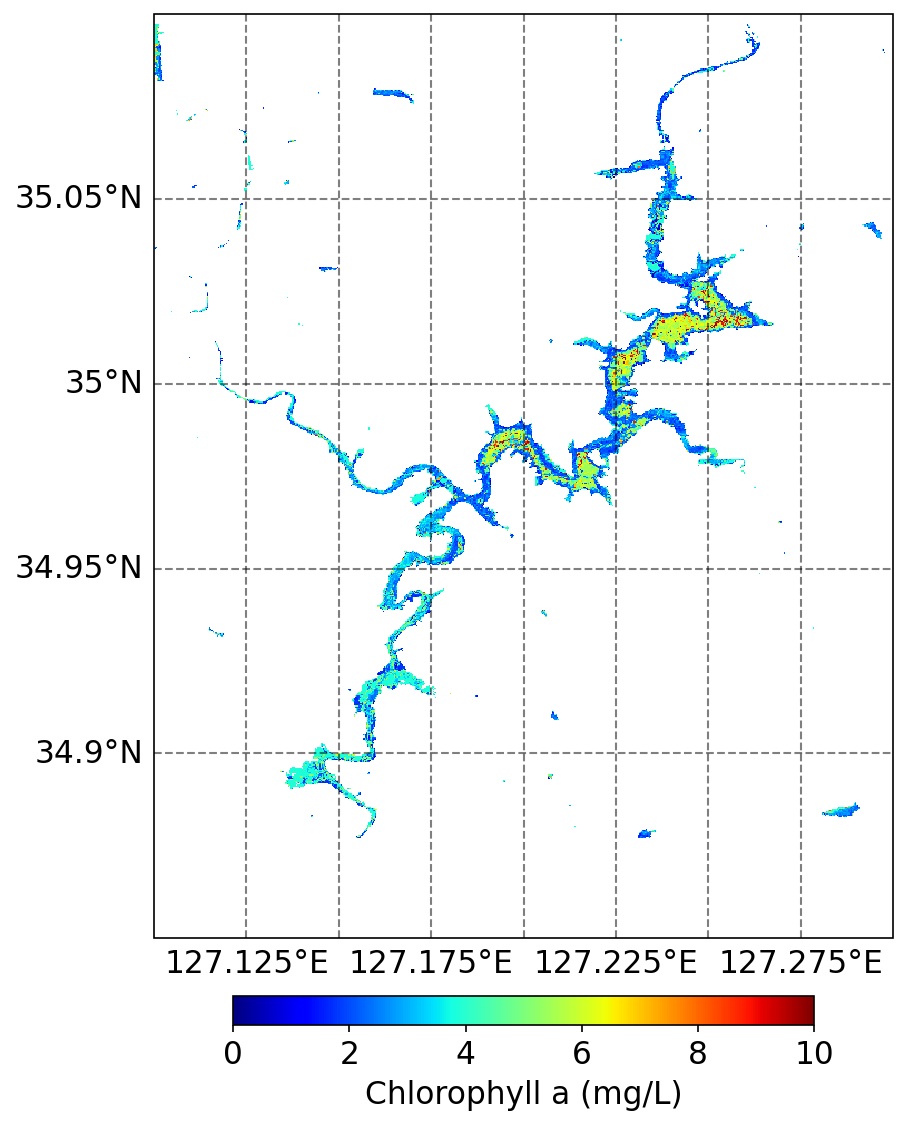

In [14]:
bounds = [127.1, 127.3, 34.85, 35.1]
Plot.plot_map(lon, lat, pred_2d_xgb, 0, 10, plot_title=target_date + (' (Juam Dam; XGBoost)'), label_title='Chlorophyll a (mg/L)', cmap='jet', projection='PlateCarree', bounds=bounds, dem_path=None);